In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.data_funcs import *
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.tools import add_constant
import seaborn as sns
import warnings
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA as ARIMA

In [2]:
df = get_overall_data_df()
df

C:\Users\gleb_\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,state,date,cases,deaths,c6_stay_at_home_requirements,days_since_more_strict,days_since_less_strict,pop_density,mobile_ppl_per100,scaled_median_income,political_index,state_0,state_1,state_2,state_3,state_4,state_5,month,year,days_since_start
0,Alabama,2020-03-13,6.0,0.0,0.0,0.0,0.0,93.536532,7.140855,-1.154048,-0.277250,0,0,0,0,0,0,3,0,73
1,Alabama,2020-03-14,6.0,0.0,0.0,0.0,0.0,93.536532,6.980729,-1.154048,-0.277250,0,0,0,0,0,0,3,0,74
2,Alabama,2020-03-15,11.0,0.0,0.0,0.0,0.0,93.536532,6.888877,-1.154048,-0.277250,0,0,0,0,0,0,3,0,75
3,Alabama,2020-03-16,6.0,0.0,0.0,0.0,0.0,93.536532,6.480950,-1.154048,-0.277250,0,0,0,0,0,0,3,0,76
4,Alabama,2020-03-17,10.0,0.0,0.0,0.0,0.0,93.536532,6.065786,-1.154048,-0.277250,0,0,0,0,0,0,3,0,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19347,Wyoming,2021-03-19,102.0,0.0,1.0,359.0,0.0,5.916995,5.174210,-0.391458,-0.462953,1,1,0,0,0,1,3,1,443
19348,Wyoming,2021-03-20,0.0,0.0,1.0,360.0,0.0,5.916995,5.258700,-0.391458,-0.462953,1,1,0,0,0,1,3,1,444
19349,Wyoming,2021-03-21,0.0,0.0,1.0,361.0,0.0,5.916995,5.351230,-0.391458,-0.462953,1,1,0,0,0,1,3,1,445
19350,Wyoming,2021-03-22,150.0,0.0,1.0,362.0,0.0,5.916995,5.727350,-0.391458,-0.462953,1,1,0,0,0,1,3,1,446


# The interrupted time-series model I:  Regression version with only slope change 
$$log(y_t) = b_0 + b_1t + (b_2x_{t,1}t_1 + b_3x_{lag,1}t_1) + (b_4x_{t,2}t_2 + b_5x_{lag,2}t_2)$$

$y_t$: new cases at time t (day t)   
$x_{t,n}$: indicator for whether we are in a policy strictness n time interval  
$x_{lag, n}$: indicator for whether we are in lag period for the policy strictness n time interval i.e. within 1.5 weeks of initial implementation of the policy strictness n    
$t_n$: time since policy strictness n was implemented


In [3]:
cal_df = df[df.state == 'California']
cal_df.reset_index()

,index,state,date,cases,deaths,c6_stay_at_home_requirements,days_since_more_strict,days_since_less_strict,pop_density,mobile_ppl_per100,...,political_index,state_0,state_1,state_2,state_3,state_4,state_5,month,year,days_since_start
0,1554,California,2020-01-25,1.0,0.0,0.0,0.0,0.0,241.377092,5.676287,...,0.301093,0,0,0,1,0,0,1,0,25
1,1555,California,2020-01-26,1.0,0.0,0.0,0.0,0.0,241.377092,5.642540,...,0.301093,0,0,0,1,0,0,1,0,26
2,1556,California,2020-01-27,0.0,0.0,0.0,0.0,0.0,241.377092,6.081676,...,0.301093,0,0,0,1,0,0,1,0,27
3,1557,California,2020-01-28,0.0,0.0,0.0,0.0,0.0,241.377092,6.190506,...,0.301093,0,0,0,1,0,0,1,0,28
4,1558,California,2020-01-29,0.0,0.0,0.0,0.0,0.0,241.377092,6.169491,...,0.301093,0,0,0,1,0,0,1,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1973,California,2021-03-19,3213.0,206.0,2.0,3.0,51.0,241.377092,5.363090,...,0.301093,0,0,0,1,0,0,3,1,443
420,1974,California,2021-03-20,2189.0,99.0,2.0,4.0,52.0,241.377092,5.264610,...,0.301093,0,0,0,1,0,0,3,1,444
421,1975,California,2021-03-21,1953.0,103.0,2.0,5.0,53.0,241.377092,5.258500,...,0.301093,0,0,0,1,0,0,3,1,445
422,1976,California,2021-03-22,2906.0,184.0,2.0,6.0,54.0,241.377092,5.270650,...,0.301093,0,0,0,1,0,0,3,1,446


In [4]:
def get_days_since_change(state_df):
    state_df = state_df.reset_index()
    first_more_strict = np.min(state_df.index[(state_df.days_since_more_strict > 0)]) - 1
    first_less_strict = np.min(state_df.index[(state_df.days_since_less_strict > 0) ]) - 1

 
    days_since_change = np.minimum(state_df.days_since_more_strict, state_df.days_since_less_strict)

    
    # before the first policy enactment mark 'days since change' as -1
    days_since_change.loc[:first_more_strict] = -1
    
    # before first less strict policy, all the days since less strict filled in as 0's, so they shouldn't
    # be considered the most recent 'days since change value'
    days_since_change.loc[first_more_strict:first_less_strict-1] = \
        state_df.days_since_more_strict.loc[first_more_strict:first_less_strict-1]
    
    return days_since_change.to_numpy()

def get_lag_indicators(n, policy_name, state_df, days_since_change, lag=15):
    state_df = state_df.reset_index()
    
    state_lag_indicator = np.where((state_df[policy_name] == n) & (days_since_change >= 0) & (days_since_change <lag), 1, 0)
    
    return state_lag_indicator
    

In [5]:
policy_name = 'c6_stay_at_home_requirements'
x_1 = np.where(cal_df[policy_name] == 1, 1, 0)
x_2 = np.where(cal_df[policy_name] == 2, 1, 0)
days_since_change = get_days_since_change(cal_df)

x_lag_1 = get_lag_indicators(1, policy_name, cal_df, days_since_change)
x_lag_2 = get_lag_indicators(2, policy_name, cal_df, days_since_change) 

check_df = cal_df[[policy_name, 'days_since_more_strict', 'days_since_less_strict']].copy()
check_df['x_1'] = x_1
check_df['x_2'] = x_2
check_df['days_since_change'] = days_since_change
check_df['x_1_lag'] = x_lag_1
check_df['x_2_lag'] = x_lag_2
check_df.to_csv('check.csv')

In [6]:
linreg_cal_df = pd.DataFrame({'t':cal_df.days_since_start})
linreg_cal_df['x_1*t_1'] = days_since_change * x_1

linreg_cal_df['x_lag_1*t_1'] = days_since_change * x_lag_1
linreg_cal_df['x_2*t_2'] = days_since_change * x_2
linreg_cal_df['x_lag_2*t_2'] = days_since_change * x_lag_2
linreg_cal_df['log(y)'] = np.log(cal_df.cases + 1)

# Reserve from Jan 15, 2021 and on as the test set 
train_cal_df = linreg_cal_df[cal_df.date < '2021-01-15']

X_train = train_cal_df.drop(columns='log(y)').to_numpy()
X_train = sm.add_constant(X_train)
y_train = train_cal_df['log(y)'].to_numpy()

In [7]:
def run_stat_linreg(X_train, y_train):
    stat_mod = sm.OLS(y_train, X_train)
    stat_reg = stat_mod.fit()
    print(stat_reg.summary())
    return stat_reg

### Result: 
Low $R^2$ and Likely autocorrelated residuals -- need to try a different model

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     146.7
Date:                Fri, 28 May 2021   Prob (F-statistic):           1.31e-83
Time:                        16:55:22   Log-Likelihood:                -678.12
No. Observations:                 356   AIC:                             1368.
Df Residuals:                     350   BIC:                             1391.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6634      0.198     13.429      0.0

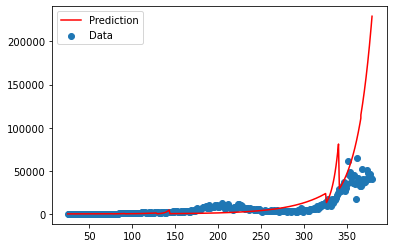

In [8]:
stat_reg = run_stat_linreg(X_train, y_train)
y_predict_insample = stat_reg.predict(X_train)
plt.plot(train_cal_df.t.to_numpy(), np.exp(y_predict_insample), color="red", label="Prediction")
plt.scatter(train_cal_df.t.to_numpy(), np.exp(train_cal_df['log(y)'].to_numpy()), label="Data")
plt.legend()

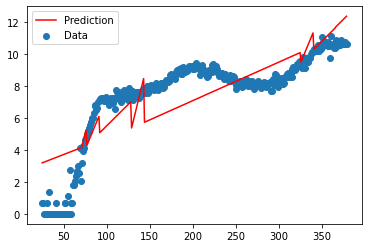

In [9]:
plt.plot(train_cal_df.t.to_numpy(), y_predict_insample, color="red", label="Prediction")
plt.scatter(train_cal_df.t.to_numpy(), train_cal_df['log(y)'].to_numpy(), label="Data")
plt.legend()


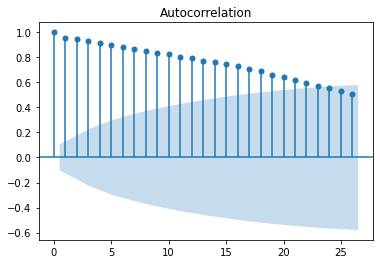

In [10]:
plot_acf(stat_reg.resid);

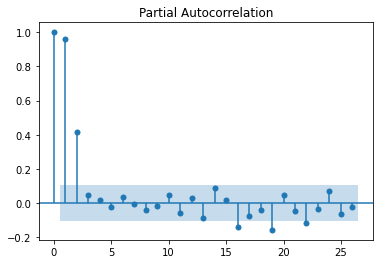

In [11]:
plot_pacf(stat_reg.resid);

<AxesSubplot:>

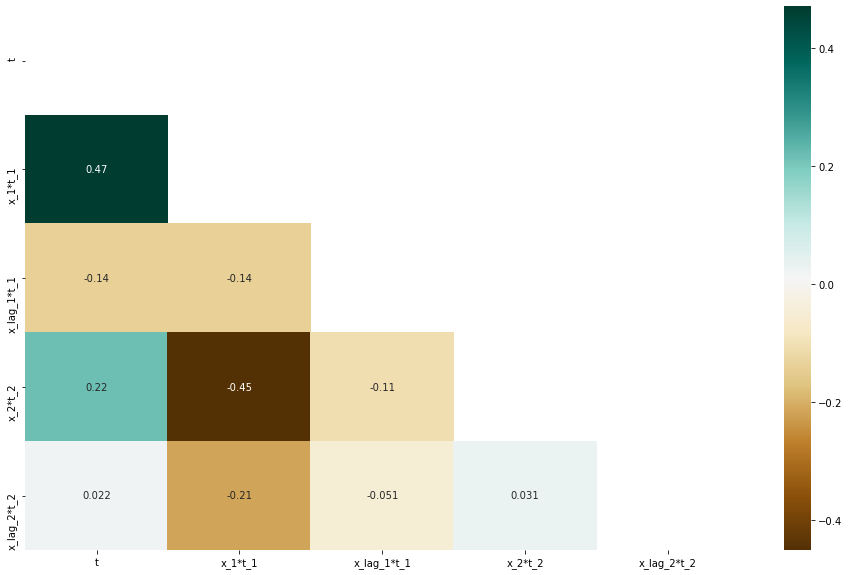

In [12]:
# Looking at correlation heatmap between input variables 
plt.figure(figsize=(16, 10))
train_corr_mat = train_cal_df.drop(columns='log(y)').corr()
sns.heatmap(train_corr_mat, annot=True, cmap='BrBG', 
           mask=np.triu(np.ones_like(train_corr_mat)))

# The interrupted time-series model II:  Regression version with slope and level change 
$$log(y_t) = b_0 + b_1t + (b_2x_{t,1}+b_3x_{t,1}t_1 + b_4x_{lag,1}t_1) + (b_5x_{t,2} + b_6x_{t,2}t_2 + b_7x_{lag,2}t_2)$$

$y_t$: new cases at time t (day t)   
$x_{t,n}$: indicator for whether we are in a policy strictness n time interval  
$x_{lag, n}$: indicator for whether we are in lag period for the policy strictness n time interval i.e. within 1.5 weeks of initial implementation of the policy strictness n    
$t_n$: time since policy strictness n was implemented


In [13]:
linreg_cal_df2 = pd.DataFrame({'t': cal_df.days_since_start,
                               'x_1': x_1,
                               'x_1*t_1': days_since_change * x_1,
                               'x_lag_1*t_1': days_since_change * x_lag_1, 
                               'x_2': x_2,
                               'x_2*t_2': days_since_change * x_2, 
                               'x_lag_2*t_2': days_since_change * x_lag_2, 
                               'log(y)': np.log(cal_df.cases + 1)})


# Reserve from Jan 15, 2021 and on as the test set 
train_cal_df2 = linreg_cal_df2[cal_df.date < '2021-01-15']
test_cal_df2 = linreg_cal_df2[cal_df.date >= '2021-01-15']
print(train_cal_df2.columns)

X_train2 = train_cal_df2.drop(columns='log(y)').to_numpy()
X_train2 = sm.add_constant(X_train2)
y_train2 = train_cal_df2['log(y)'].to_numpy()

X_test2 = test_cal_df2.drop(columns='log(y)').to_numpy()
X_test2 = sm.add_constant(X_test2)

# Run lin reg
stat_reg = run_stat_linreg(X_train2, y_train2)

Index(['t', 'x_1', 'x_1*t_1', 'x_lag_1*t_1', 'x_2', 'x_2*t_2', 'x_lag_2*t_2',
       'log(y)'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     852.1
Date:                Fri, 28 May 2021   Prob (F-statistic):          1.06e-214
Time:                        16:55:24   Log-Likelihood:                -363.38
No. Observations:                 356   AIC:                             742.8
Df Residuals:                     348   BIC:                             773.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------

<AxesSubplot:>

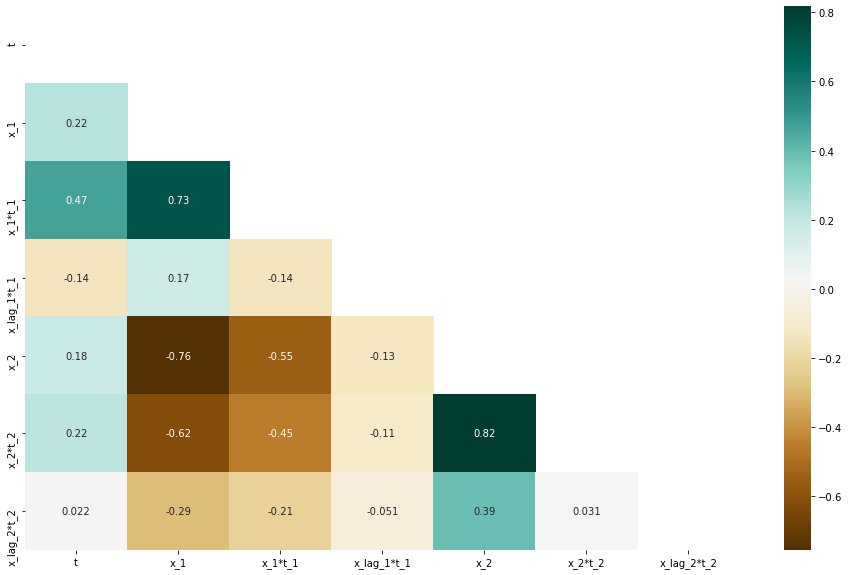

In [14]:
# Looking at correlation heatmap between input variables 
plt.figure(figsize=(16, 10))
train_corr_mat = train_cal_df2.drop(columns='log(y)').corr()
sns.heatmap(train_corr_mat, annot=True, cmap='BrBG', 
           mask=np.triu(np.ones_like(train_corr_mat)))

###  Result

The $R^2$ is significantly improved although we can see by inspection below that the prediction in the test set is not very good. This model is limited by the linear nature of the trend. The PACF and ACF plots also show there is autocorrelation among the residuals.

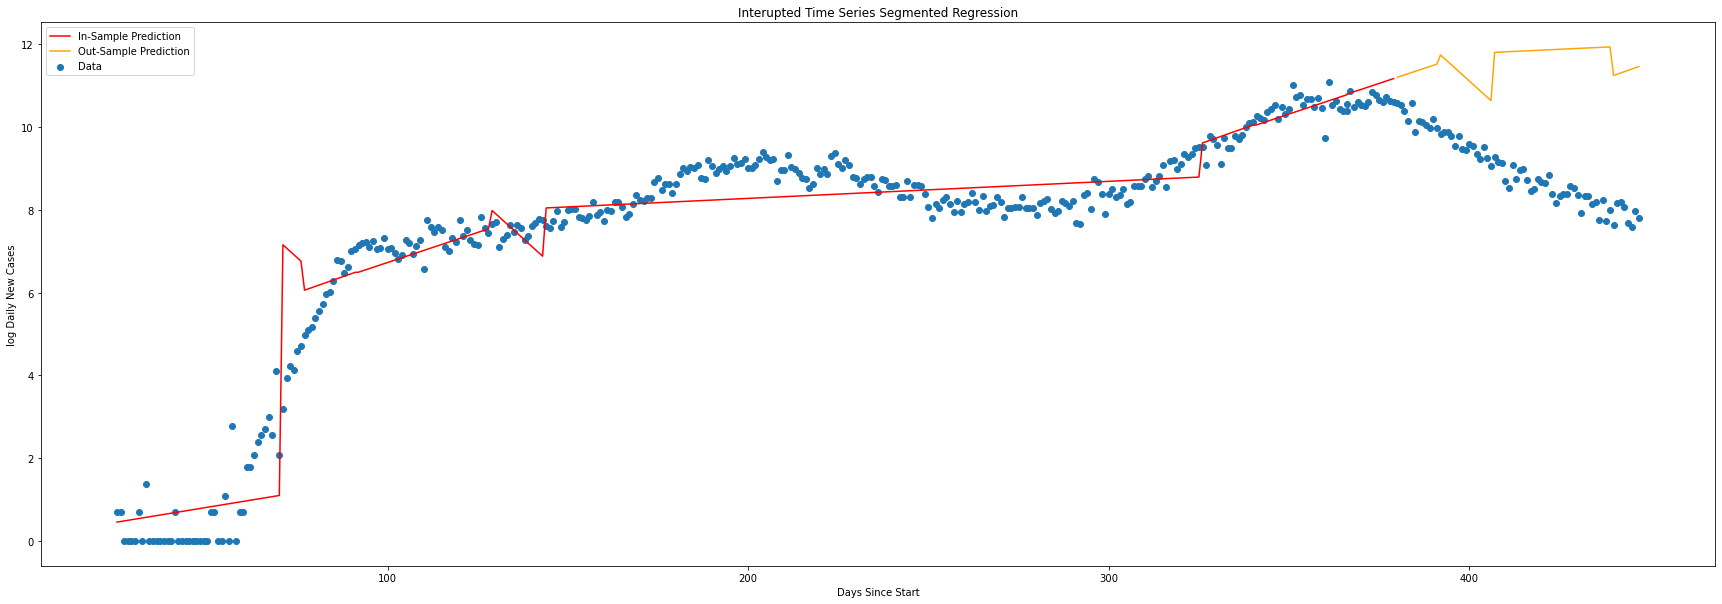

In [15]:
fig = plt.figure(figsize=(30,10))
y_predict_insample2 = stat_reg.predict(X_train2)
y_predict_outsample2 = stat_reg.predict(X_test2)

plt.plot(train_cal_df2.t.to_numpy(), y_predict_insample2, color="red", label="In-Sample Prediction")
plt.scatter(linreg_cal_df2.t.to_numpy(), linreg_cal_df2['log(y)'].to_numpy(), label="Data")
plt.plot(test_cal_df2.t.to_numpy(), y_predict_outsample2, color="orange", label="Out-Sample Prediction")

plt.plot()
plt.xlabel('Days Since Start')
plt.ylabel('log Daily New Cases')
plt.title("Interupted Time Series Segmented Regression")
plt.legend()

#### Interpreting the plots below:
"*Consider a time series that was generated by an autoregression (AR) process with a lag of k. We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information. This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened. We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.*"

~~ https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

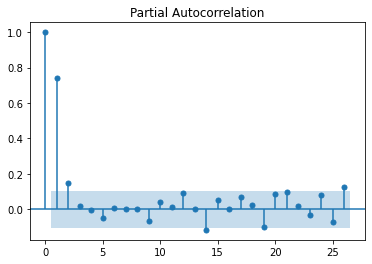

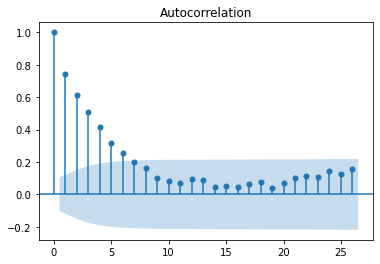

In [16]:
plot_pacf(stat_reg.resid);
plot_acf(stat_reg.resid);

In [17]:
# The in-sample mean squared error of the model
stat_reg.mse_model

393.08844194992855

## Interupted Time Series III: model II segmented regression with ARIMA(1,1,0) errors 

To take into account lag one autoregressive correlation of residuals.


In [18]:
linreg_cal_df3 = pd.DataFrame({'t': cal_df.days_since_start,
                               'x_1': x_1,
                               'x_1*t_1': days_since_change * x_1,
                               'x_lag_1*t_1': days_since_change * x_lag_1, 
                               'x_2': x_2,
                               'x_2*t_2': days_since_change * x_2, 
                               'x_lag_2*t_2': days_since_change * x_lag_2, 
                               'log(y)': np.log(cal_df.cases + 1)})


# Reserve from Jan 15, 2021 and on as the test set 
train_cal_df3 = linreg_cal_df3[cal_df.date < '2021-01-15']
test_cal_df3 = linreg_cal_df3[cal_df.date >= '2021-01-15']

X_test3 = test_cal_df3.drop(columns='log(y)').to_numpy()
y_test3 = test_cal_df3['log(y)'].to_numpy()

X_train3 = train_cal_df3.drop(columns='log(y)').to_numpy()
y_train3 = train_cal_df3['log(y)'].to_numpy()

arima_reg_model = ARIMA(endog=y_train3, exog=X_train3,order=(1,1,0))
arima_reg_results = arima_reg_model.fit()

In [19]:
arima_reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  356
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -112.495
Date:                Fri, 28 May 2021   AIC                            242.990
Time:                        16:55:28   BIC                            277.839
Sample:                             0   HQIC                           256.853
                                - 356                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0264      0.013      1.972      0.049       0.000       0.053
x2             0.5124      0.156      3.288      0.001       0.207       0.818
x3             0.0027      0.006      0.449      0.654      -0.009       0.015
x4             0.0203      0.050      0.403      0.687      -0.078       0.119
x5             0.8432      1.115      0.756      0.449      -1.342       3.028
x6            -0.0077      0.024     -0.322      0.747      -0.054       0.039
x7             0.0037      0.029      0.125      0.900      -0.054       0.061
ar.L1         -0.5306      0.022    -23.882      0.000      -0.574      -0.487
sigma2         0.1103      0.005     22.030      0.000       0.100       0.120
===================================================================================
Ljung-Box (L1) (Q):                   3.44   Jarque-Bera (JB):               681.48
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                             0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
train_cal_df3.columns

Index(['t', 'x_1', 'x_1*t_1', 'x_lag_1*t_1', 'x_2', 'x_2*t_2', 'x_lag_2*t_2',
       'log(y)'],
      dtype='object')

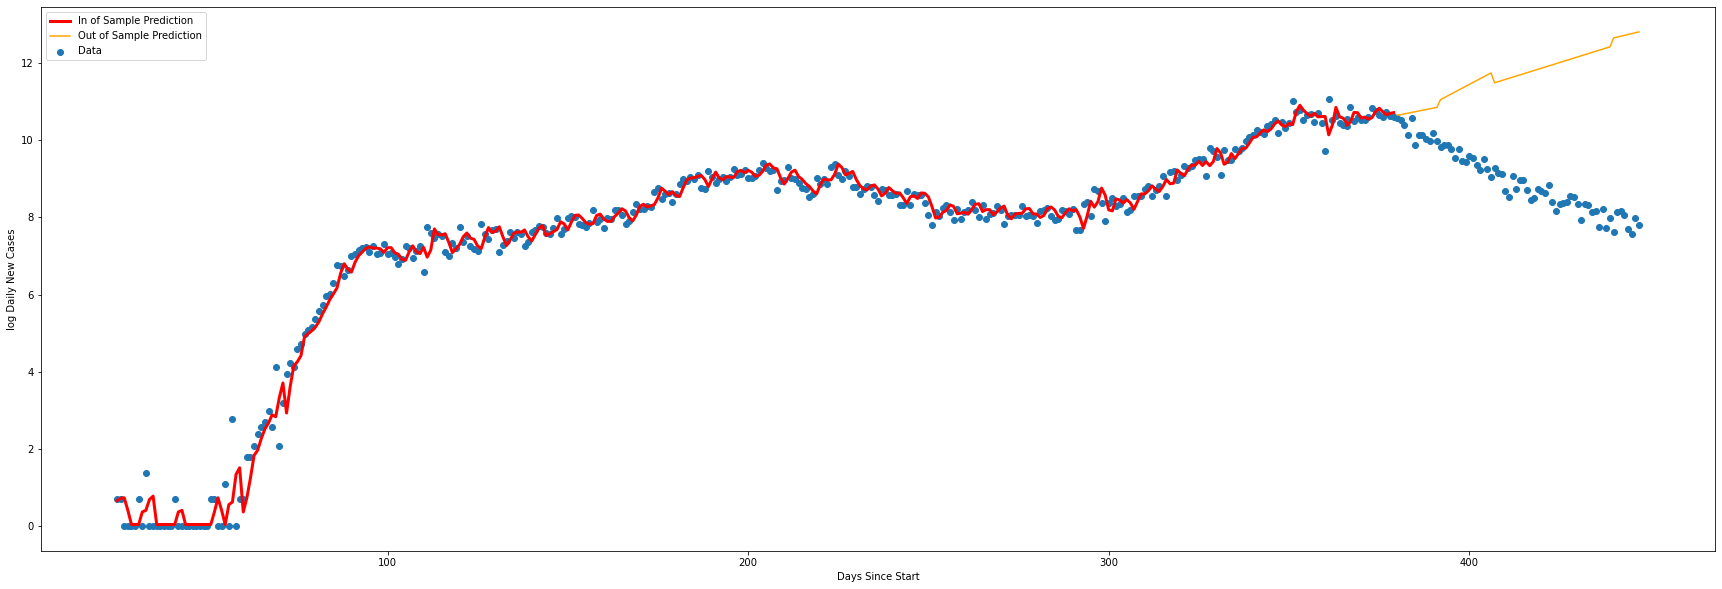

In [21]:
y_predict_insample3 = arima_reg_results.predict(exog=X_train3)
train_cal_cf_df = train_cal_df3.copy()
train_cal_cf_df['x_1']= 0
train_cal_cf_df['x_1*t_1']= 0
train_cal_cf_df['x_lag_1*t_1']= 0
train_cal_cf_df['x_2']= 0
train_cal_cf_df['x_2*t_2']= 0
train_cal_cf_df['x_lag_2*t_2']= 0

X_train_cf = train_cal_cf_df.drop(columns='log(y)').to_numpy()

y_counterfactual_insample = arima_reg_results.predict(start=0, end=(X_train_cf.shape[0])-1)
y_predict_outsample3 = arima_reg_results.forecast(steps=len(X_test3),exog=X_test3)

fig = plt.figure(figsize=(30,10))
plt.scatter(linreg_cal_df3.t.to_numpy(), linreg_cal_df3['log(y)'].to_numpy(), label="Data")
plt.plot(train_cal_df3.t.to_numpy(), y_predict_insample3, color="red", label="In of Sample Prediction", linewidth=3)
plt.plot(test_cal_df3.t.to_numpy(), y_predict_outsample3, color="orange", label="Out of Sample Prediction")
plt.xlabel('Days Since Start')
plt.ylabel('log Daily New Cases')
plt.legend()

## Interupted Time Series IV: Different the ARIMA Methodology

Following this:

"*Two parts of the overall model have to be estimated – the basic ARIMA model for the series and the intervention effect. Several approaches have been proposed. One approach has the following steps:*
1. *Use the data before the intervention point to determine the ARIMA model for the series.*
2. *Use that ARIMA model to forecast values for the period after the intervention.*
3. *Calculate the differences between actual values after the intervention and the forecasted values.*
4. *Examine the differences in step 3 to determine a model for the intervention effect.*
*What we do after step 4 depends on available software. If the right program is available we can use all of the data to estimate the overall model that combines the ARIMA for the series and the intervention model. Otherwise, we might use only the differences from step 4 above to make estimates of the magnitude and nature of the intervention*"

~~ https://online.stat.psu.edu/stat510/lesson/9/9.2


In [23]:
# first wave and second wave: we will focus on the second wave for our models below 
fw_cal_df = cal_df[cal_df.date < '2020-09-01'].copy()
fw_cal_df['days_since_chance'] = get_days_since_change(cal_df)[cal_df.date < '2020-09-01']

sw_cal_df = cal_df[cal_df.date >= '2020-09-01'].copy()
sw_cal_df['days_since_change'] = get_days_since_change(cal_df)[cal_df.date >='2020-09-01']
sw_cal_df['log_cases'] = (np.log(sw_cal_df.cases + 1)).to_numpy()


# Refer to initial_data_manip.ipynb and run the following function to see the prograssion of the policy
# alongside the COVID daily case data over time:
# plot_state_policy_window(policy_df, us_state_daily_df, '2020-01-21', '2021-05-01', 'California', 'c6_stay_at_home_requirements', 'cases')

# day_of_intervention: The day that the first (since the start of the second wave) level-2 strictness lockdown was enacted
day_of_intervention = '2020-11-21'
day_end_of_training_set = '2021-02-16'
day_end_of_test_set = '2021-03-16'

sw_cal_prepolicy_df = sw_cal_df[sw_cal_df.date < day_of_intervention].copy()

sw_train_prepolicy = pd.DataFrame({'t': sw_cal_prepolicy_df.days_since_start,
                                   'date': sw_cal_prepolicy_df.date,
                                   'log_cases':(np.log(sw_cal_prepolicy_df.cases + 1))})

sw_all_postpolicy = sw_cal_df[(sw_cal_df.date >= day_of_intervention) & (sw_cal_df.date < day_end_of_test_set)].copy()


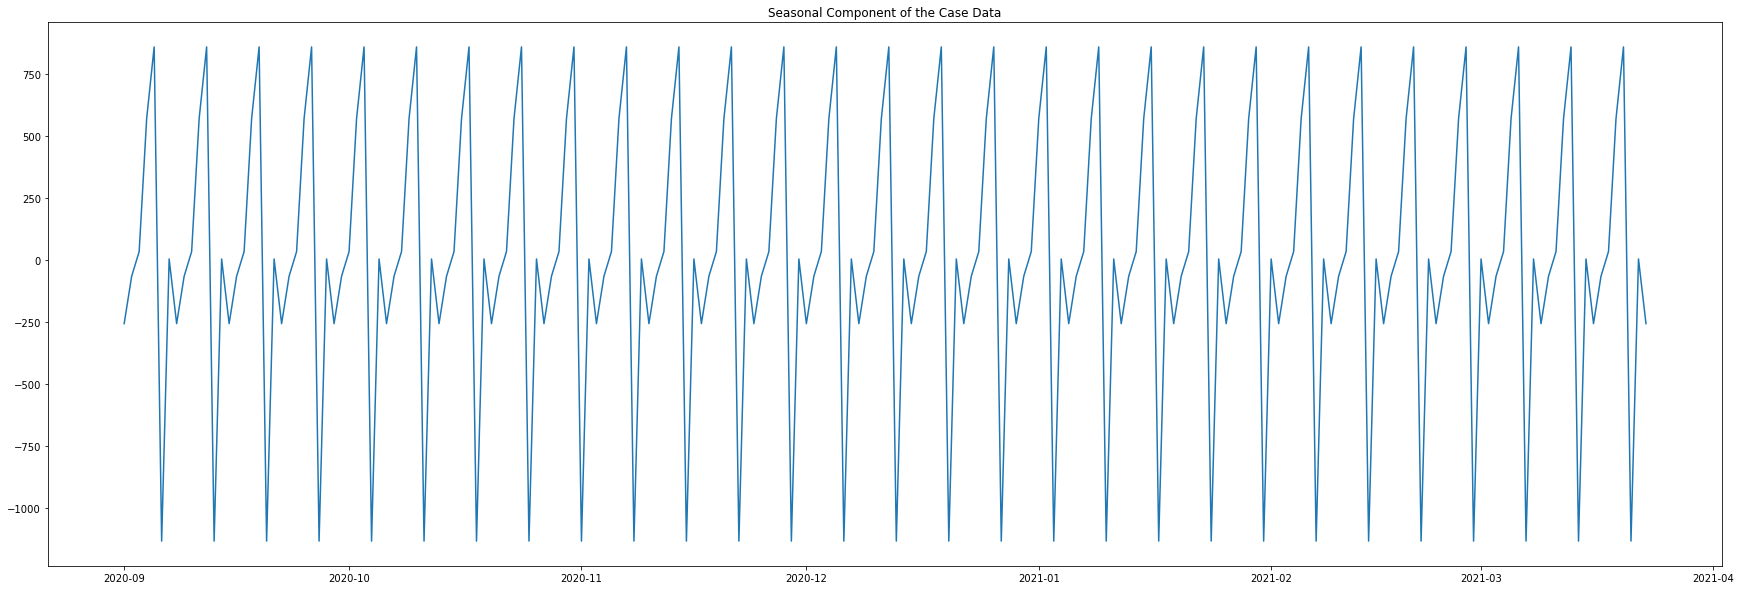

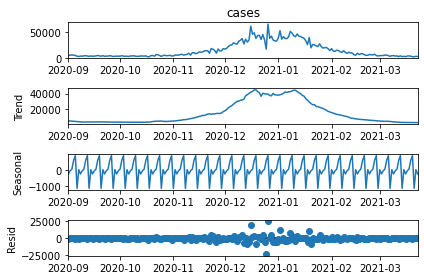

In [25]:
# Finding the seasonal decomposition of the case data

sw_cal_df2 = sw_cal_df.set_index('date')
sw_cal_df2 = sw_cal_df2.asfreq('D')
sw_cal_df2
decomp = seasonal_decompose(sw_cal_df2['cases'], model='additive', 
                            extrapolate_trend='freq'); 
fig = plt.figure(figsize=(30,10))
plt.plot(decomp.seasonal)
# Shows a weekly (every 7 days) seasonal pattern
plt.title('Seasonal Component of the Case Data')
decomp.plot();


In [43]:
# Training the prepolicy model and producing the counterfactual 
def get_prepolicy_results(sw_train_prepolicy):
    prepolicy_model = ARIMA(endog=sw_train_prepolicy.log_cases.to_numpy(),order=(0,1,1), seasonal_order=(1,1,0,7))
    prepolicy_res= prepolicy_model.fit()
    display(prepolicy_res.summary())
    return prepolicy_res

def get_prepolicy_model_counterfactual_plot(sw_train_prepolicy, sw_cal_df, prepolicy_res, day_end_of_test_set,
                                           day_of_intervention, day_end_of_training_set, sw_all_postpolicy):
    fig = plt.figure(figsize=(30,10))
    plt.ylabel('log cases')
    plt.scatter(sw_cal_df.date, sw_cal_df.log_cases)
    plt.plot(sw_cal_df.date, sw_cal_df.log_cases)
    plt.plot(sw_cal_prepolicy_df.date.iloc[1:],prepolicy_res.predict(start=1), 
             label='ARIMA Pre-Policy In-Sample Fit')
    fcast_cf = prepolicy_res.get_forecast(steps=(pd.to_datetime(day_end_of_test_set) - pd.to_datetime(day_of_intervention) ).days).summary_frame()
    y_counterfactual = fcast_cf['mean']
    plt.plot(sw_all_postpolicy.date,
             y_counterfactual, 
             label='ARIMA Pre-Policy Forecast: Counterfactual' , color='red')
    #plot confidence interval
    plt.fill_between(sw_all_postpolicy.date,
                    fcast_cf['mean_ci_lower'],
                    fcast_cf['mean_ci_upper'], color='k', alpha=0.1);
    
    plt.axvline(x=day_of_intervention, color='red', label='Day Of Intervention')
    plt.axvline(x=day_end_of_training_set, color='green', label='End of Post Policy Training Set')
    plt.axvline(x=day_end_of_test_set, color='black', label='End of Post Policy Test Set')
    plt.legend()
    return y_counterfactual

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                   81
Model:             ARIMA(0, 1, 1)x(1, 1, [], 7)   Log Likelihood                  11.746
Date:                          Fri, 28 May 2021   AIC                            -17.492
Time:                                  17:06:41   BIC                            -10.620
Sample:                                       0   HQIC                           -14.753
                                           - 81                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6805      0.082     -8.343      0.000      -0.840      -0.521
ar.S.L7       -0.4990      0.084     -5.912      0.000      -0.664      -0.334
sigma2         0.0409      0.006      7.007      0.000       0.029       0.052
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 4.58
Prob(Q):                              0.68   Prob(JB):                         0.10
Heteroskedasticity (H):               1.05   Skew:                             0.59
Prob(H) (two-sided):                  0.91   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

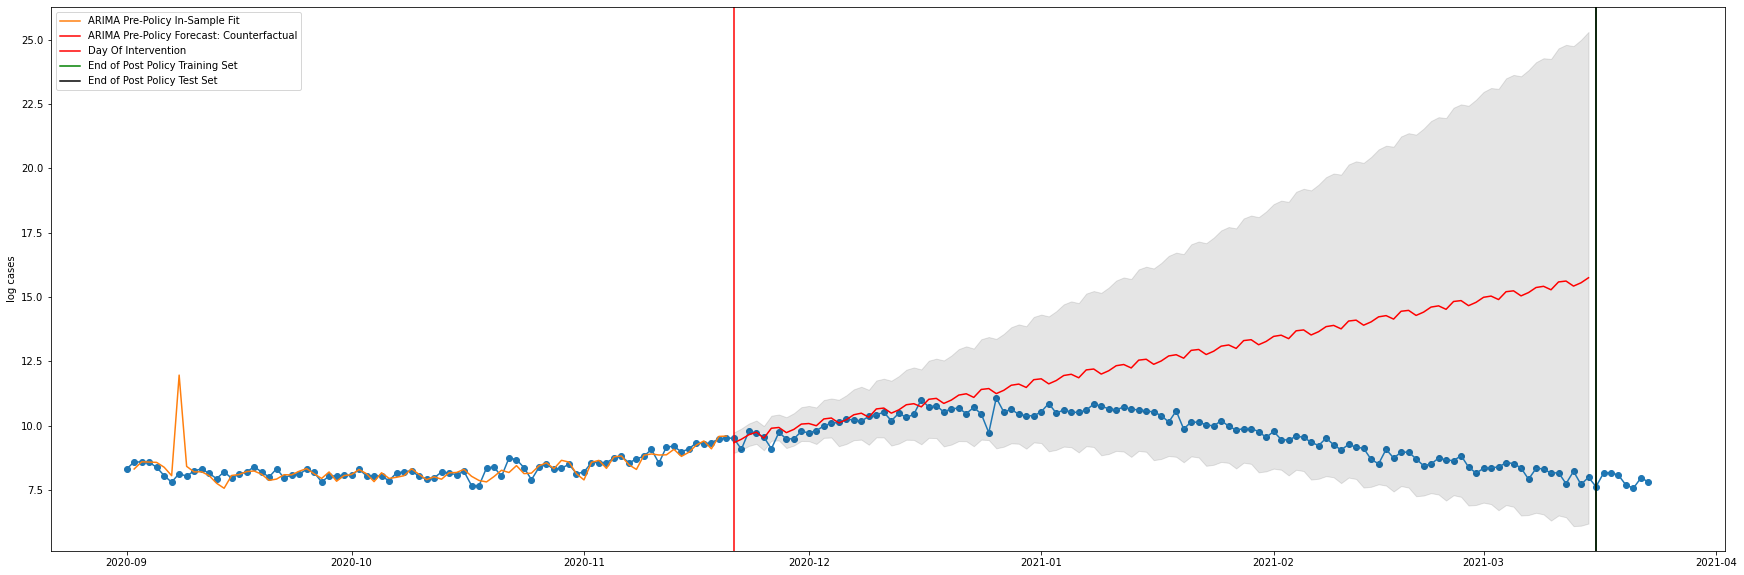

In [44]:
prepolicy_res = get_prepolicy_results(sw_train_prepolicy)
y_counterfactual = get_prepolicy_model_counterfactual_plot(sw_train_prepolicy, sw_cal_df, prepolicy_res, day_end_of_test_set,
                                           day_of_intervention, day_end_of_test_set, sw_all_postpolicy);

Text(0.5, 1.0, 'Differences between actual log cases postpolicy and counterfactual')

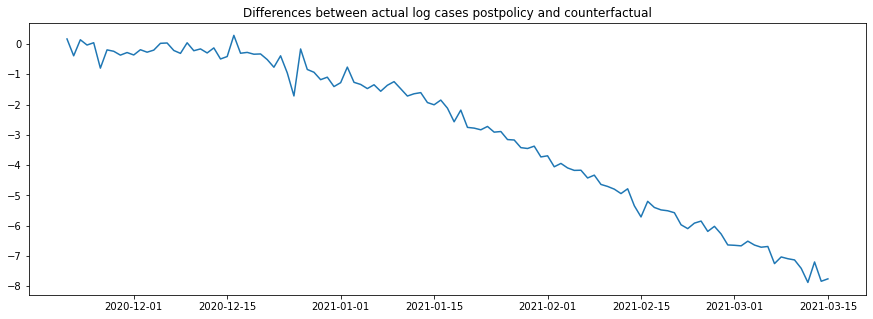

In [45]:
# Days after (and including) policy strictness 2 enactment until the next policy strictening
sw_train_postpolicy = sw_cal_df[(sw_cal_df.date >= day_of_intervention) & (sw_cal_df.date < day_end_of_training_set)].copy()

sw_test_postpolicy = sw_cal_df[(sw_cal_df.date >= day_end_of_training_set) & (sw_cal_df.date < day_end_of_test_set)].copy()

num_days_postpolicy = sw_train_postpolicy.shape[0] + sw_test_postpolicy.shape[0]

# Difference between counterfactual and actual log cases in the post policy period (before end of test set)
diff_cf_actual = sw_all_postpolicy['log_cases'].to_numpy()  - y_counterfactual.to_numpy()

num_days_train_postpolicy = (pd.to_datetime(day_end_of_training_set) - pd.to_datetime(day_of_intervention)).days
# Seperate differences into test and train
diff_cf_actual_train = diff_cf_actual[:num_days_train_postpolicy]
diff_cf_actual_test = diff_cf_actual[num_days_train_postpolicy:]


fig = plt.figure(figsize=(15,5))
plt.plot(sw_all_postpolicy.date, diff_cf_actual)
plt.title('Differences between actual log cases postpolicy and counterfactual')


In [46]:
def get_postpolicy_results(diff_cf_actual_train, lag, order, sorder): 
    
    endog_w_lag = diff_cf_actual_train[lag:]
    model_diff = ARIMA(endog= endog_w_lag, order=order,seasonal_order=sorder, trend='c')
    res_diff= model_diff.fit()
    
    # Display summary of fit 
    display(res_diff.summary())
    
    # Plot statistical diagnostics of model
    fig = res_diff.plot_diagnostics()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    
    return res_diff


def get_RMSE_test(diff_cf_actual_test, res_diff):
    fcast = res_diff.forecast(steps=len(diff_cf_actual_test))
    RMSE = mean_squared_error(diff_cf_actual_test, fcast, squared=False )
    return RMSE

def get_postpolicy_model_plots(lag, sw_all_postpolicy, sw_test_postpolicy, day_end_of_training_set,
                               diff_cf_actual_train, diff_cf_actual, res_diff):
    
    # Make insample predictions and out of sample forecasts 
    fcast = res_diff.get_prediction(end=sw_all_postpolicy.shape[0]-lag-1).summary_frame()
    
    fig, ax = plt.subplots(figsize=(15,5))
    # Plot actuals
    ax.plot(sw_all_postpolicy.date, diff_cf_actual, label='actual diffs')
    
    ax.plot(sw_all_postpolicy.date.iloc[lag:], fcast['mean'], label='predicted diffs')

    #plot confidence interval
    ax.fill_between(sw_test_postpolicy.date,
                    fcast.loc[fcast.index > len(diff_cf_actual_train)-lag-1, 'mean_ci_lower'],
                    fcast.loc[fcast.index > len(diff_cf_actual_train)-lag-1, 'mean_ci_upper'], color='k', alpha=0.1);




    plt.axvline(x=day_end_of_training_set, label='End of Training Set', color='black')
    plt.legend()
    

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                               y   No. Observations:                   62
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood                  -4.991
Date:                         Fri, 28 May 2021   AIC                             17.981
Time:                                 17:06:49   BIC                             25.937
Sample:                                      0   HQIC                            21.049
                                          - 62                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.398e-09   1.19e-09      4.543      0.000    3.07e-09    7.73e-09
ma.L1         -0.6614      0.143     -4.633      0.000      -0.941      -0.382
ma.S.L7       -0.6694      0.242     -2.771      0.006      -1.143      -0.196
sigma2         0.0644      0.013      4.972      0.000       0.039       0.090
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):                30.03
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                             0.81
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+24. Standard errors may be unstable.
"""

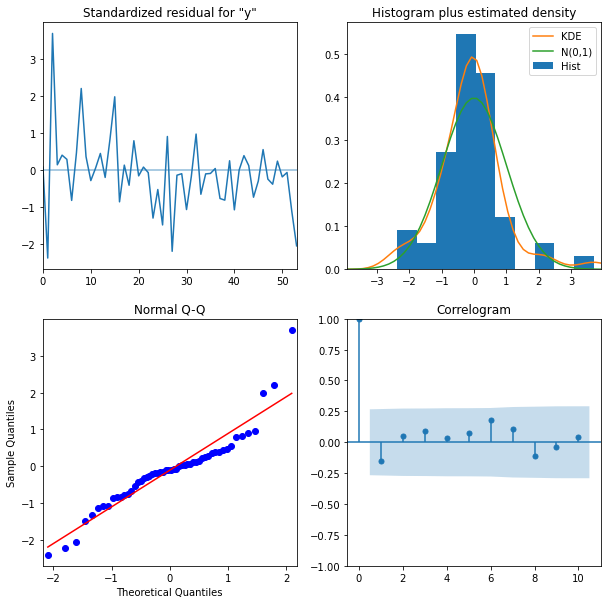

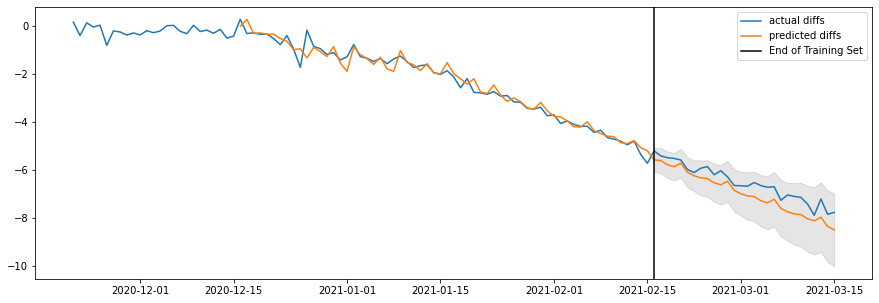

Test RMSE: 0.4825426869054486


In [47]:
# Trying the model with handpicked params
res_diff = get_postpolicy_results(diff_cf_actual_train, lag=25, order=(0,1,1), sorder=(0,1,1,7))
get_postpolicy_model_plots(25, sw_all_postpolicy, sw_test_postpolicy, day_end_of_training_set,
                               diff_cf_actual_train, diff_cf_actual, res_diff)
plt.show()
print(f'Test RMSE: {get_RMSE_test(diff_cf_actual_test, res_diff)}')

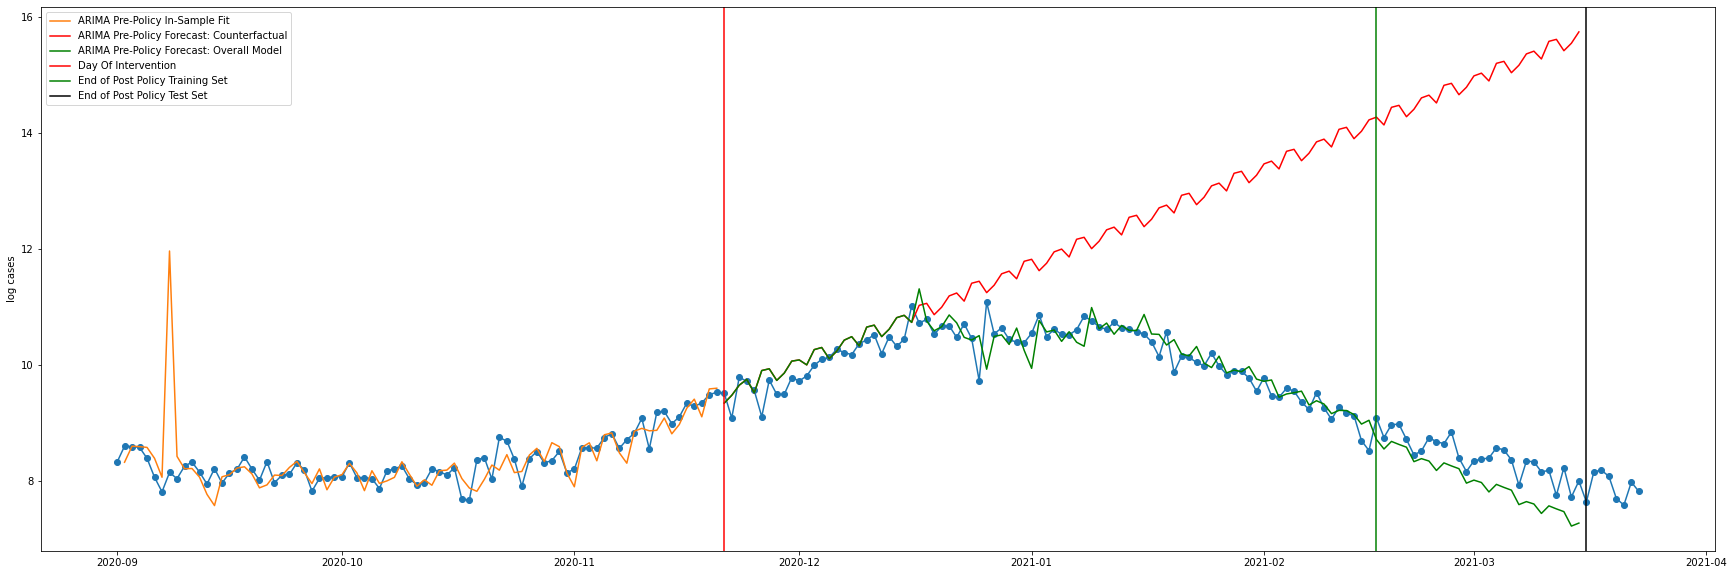

In [48]:
fig = plt.figure(figsize=(30,10))
plt.ylabel('log cases')
plt.scatter(sw_cal_df.date, sw_cal_df.log_cases)
plt.plot(sw_cal_df.date, sw_cal_df.log_cases)

plt.plot(sw_cal_prepolicy_df.date.iloc[1:],prepolicy_res.predict(start=1), 
         label='ARIMA Pre-Policy In-Sample Fit')

fcast = res_diff.get_prediction(end=sw_all_postpolicy.shape[0]-25-1).summary_frame()
    
y_counterfactual = prepolicy_res.forecast(steps=(pd.to_datetime(day_end_of_test_set) - pd.to_datetime(day_of_intervention) ).days)
y_overall_model = y_counterfactual.copy()
y_overall_model[25:] += fcast['mean']

plt.plot(sw_all_postpolicy.date,
         y_counterfactual, 
         label='ARIMA Pre-Policy Forecast: Counterfactual' , color='red')

plt.plot(sw_all_postpolicy.date,
         y_overall_model, 
         label='ARIMA Pre-Policy Forecast: Overall Model' , color='green')

plt.axvline(x=day_of_intervention, color='red', label='Day Of Intervention')
plt.axvline(x=day_end_of_training_set, color='green', label='End of Post Policy Training Set')
plt.axvline(x=day_end_of_test_set, color='black', label='End of Post Policy Test Set')
plt.legend()


### Trying to grid search to find the best postpolicy model

In [52]:
def get_opt_lag_and_postpolicy_model(diff_cf_actual_train, diff_cf_actual_test, criteria='Avg'):
    warnings.filterwarnings("ignore")
    best_lag = None
    best_order = None
    best_seasonal_order = None
    # score is taken as the average between the RMSE and 
    # the AIC -- best mean lower
    best_score = np.inf
    
    all_orders = [(1,1,1), (1,1,0), (0,1,1), (0,0,1), (0,1,0), (1,0,1), (1,0,0),(0,0,1)]
    
    for lag in range(30):
        for order in all_orders: 
            for sorder in all_orders:
                list_sorder = list(sorder)
                list_sorder.append(7)
                sorder = tuple(list_sorder)
                
                endog_w_lag = diff_cf_actual_train[lag:]
                model_diff = ARIMA(endog= endog_w_lag, order=order,seasonal_order=sorder, trend='c')
                res_diff= model_diff.fit()
                fcast = res_diff.get_forecast(steps=len(diff_cf_actual_test)).summary_frame()
                #RMSE of the test set
                RMSE = mean_squared_error(diff_cf_actual_test, 
                                          fcast['mean'], 
                                          squared=False )
                AIC = res_diff.aic
                if criteria=='Avg' and best_score > ((RMSE+AIC)/2):
                    best_order = order
                    best_seasonal_order = sorder
                    best_lag = lag
                    best_score = ((RMSE+AIC)/2)
                if criteria=='RMSE' and best_score > RMSE:
                    best_order = order
                    best_seasonal_order = sorder
                    best_lag = lag
                    best_score = RMSE
                    
                    
                    
    return (best_lag, best_order, best_seasonal_order)


In [53]:
best_lag, best_order, best_seasonal_order = get_opt_lag_and_postpolicy_model(diff_cf_actual_train,
                                                                             diff_cf_actual_test, criteria='RMSE')

18 (0, 1, 1) (1, 0, 1, 7)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                               y   No. Observations:                   69
Model:             ARIMA(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood                  -7.615
Date:                         Fri, 28 May 2021   AIC                             25.230
Time:                                 17:25:23   BIC                             36.328
Sample:                                      0   HQIC                            29.627
                                          - 69                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.316e-07    4.9e+04  -1.49e-11      1.000   -9.61e+04    9.61e+04
ma.L1         -0.5689      0.078     -7.281      0.000      -0.722      -0.416
ar.S.L7        0.9126      0.136      6.707      0.000       0.646       1.179
ma.S.L7       -0.6050      0.246     -2.463      0.014      -1.086      -0.124
sigma2         0.0682      0.011      6.296      0.000       0.047       0.089
===================================================================================
Ljung-Box (L1) (Q):                   4.16   Jarque-Bera (JB):               149.75
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

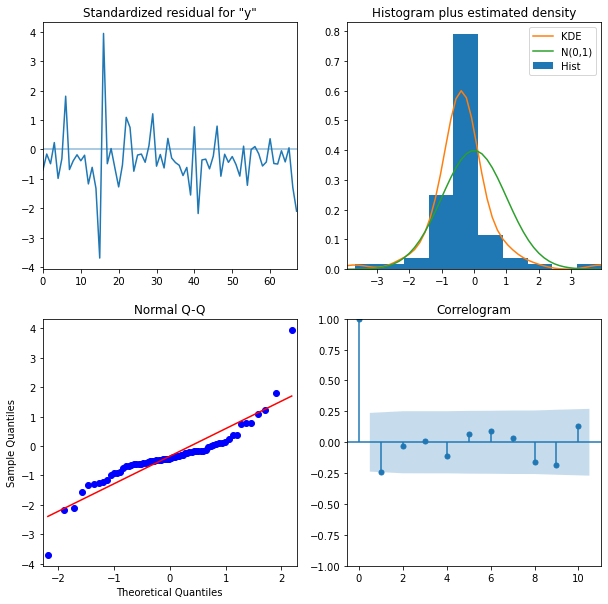

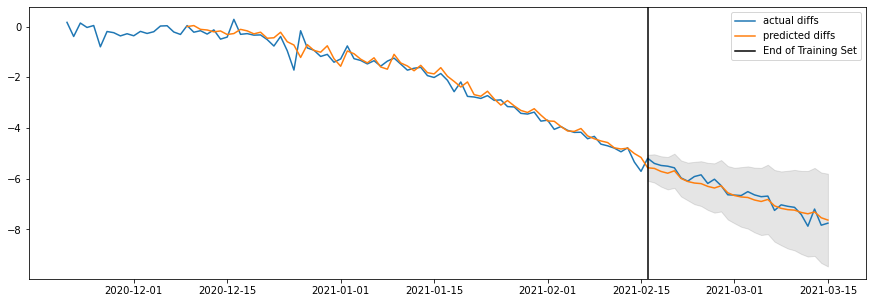

Test RMSE: 0.210696843471473


In [55]:
print(best_lag, best_order, best_seasonal_order)
res_diff = get_postpolicy_results(diff_cf_actual_train, best_lag, best_order, best_seasonal_order)
get_postpolicy_model_plots(best_lag, sw_all_postpolicy, sw_test_postpolicy, day_end_of_training_set,
                               diff_cf_actual_train, diff_cf_actual, res_diff)

plt.show()
print(f'Test RMSE: {get_RMSE_test(diff_cf_actual_test, res_diff)}')

Note that the above Ljung-Box p-test was too low, so went with the handpicked parmeters for final presentation